
---

# Filament Decorrelation Analysis
Analysis of various decorellation parameters.

---


In [1]:
import sys
if 'init_modules' in globals().keys():
    # second or subsequent run: remove all but initially loaded modules
    for m in sys.modules.keys():
        if m not in init_modules:
            del(sys.modules[m])
else:
    # first run: find out which modules were initially loaded
    init_modules = sys.modules.keys()
    
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import interpolate
import pandas as pd


import os
import pyfilaments.analysisutils as analysis
import imp
imp.reload(analysis)
%matplotlib notebook
plt.close('all')

# Figure parameters
from matplotlib import rcParams
from matplotlib import rc
from matplotlib import cm
from tqdm import tqdm

rc('font', family='sans-serif') 
rc('font', serif='Helvetica') 
rc('text', usetex='false') 
rcParams.update({'font.size': 12})

publication_figures = '/home/deepak/Dropbox/LacryModeling/ActiveFilamentsManuscript/Figures'


linux system
dict_keys(['builtins', 'sys', '_frozen_importlib', '_imp', '_warnings', '_thread', '_weakref', '_frozen_importlib_external', '_io', 'marshal', 'posix', 'zipimport', 'encodings', 'codecs', '_codecs', 'encodings.aliases', 'encodings.utf_8', '_signal', '__main__', 'encodings.latin_1', 'io', 'abc', '_weakrefset', '_bootlocale', '_locale', 'site', 'os', 'errno', 'stat', '_stat', 'posixpath', 'genericpath', 'os.path', '_collections_abc', '_sitebuiltins', 'sysconfig', '_sysconfigdata_m_linux_x86_64-linux-gnu', 'types', 'functools', '_functools', 'collections', 'operator', '_operator', 'keyword', 'heapq', '_heapq', 'itertools', 'reprlib', '_collections', 'weakref', 'collections.abc', 'importlib', 'importlib._bootstrap', 'importlib._bootstrap_external', 'warnings', 'importlib.util', 'importlib.abc', 'importlib.machinery', 'contextlib', 'mpl_toolkits', 'sphinxcontrib', 'runpy', 'pkgutil', 'ipykernel', 'ipykernel._version', 'ipykernel.connect', '__future__', 'json', 'json.decoder', '

## Define all functions

In [2]:
# Function to calculate the start and end indices corresponding to compression and extension
phases = ['compression', 'extension']

def find_extension_compression_endpoints(filament = None):
    phase_value_compression = 0

    # Phase indices at start of compression
    delta_phase = 2*np.pi*np.mean(filament.Time[1:] - filament.Time[:-1])/filament.activity_timescale # Smallest change in phase

    abs_val_array = np.abs(filament.derived_data['Phase'] - phase_value_compression)
    constant_phase_mask = abs_val_array <= 0.5*delta_phase

    time_points = np.array(range(0, filament.Nt))
    constant_phase_compression = time_points[constant_phase_mask]

    # Phase indices at start of extension
    phase_value_extension = np.pi

    abs_val_array = np.abs(filament.derived_data['Phase'] - phase_value_extension)

    min_phase = np.min(abs_val_array)
    constant_phase_mask = abs_val_array <= min_phase
    constant_phase_extension = np.array(time_points[constant_phase_mask])

    # Keep only indices separated by more than 1

    temp_array = []

    for ii in range(len(constant_phase_extension)):

        if(ii == len(constant_phase_extension)-1):
            temp_array.append(constant_phase_extension[ii])

        elif(constant_phase_extension[ii+1] - constant_phase_extension[ii] > 1):
            temp_array.append(constant_phase_extension[ii])

    constant_phase_extension = np.array(temp_array)
    
    # Store tuples containing (Start, End) indices for compression phase and extension phase
    start_end_compression = np.empty((2, filament.activity_cycles), dtype = int)
    start_end_extension = np.empty((2, filament.activity_cycles), dtype = int)
    
    for ii in range(filament.activity_cycles):
    
        start_end_compression[:,ii] = constant_phase_compression[ii], constant_phase_extension[ii]
        start_end_extension[:,ii] = constant_phase_extension[ii], constant_phase_compression[ii+1]
    
    assert(start_end_compression[1,ii]-start_end_compression[0,ii] >0)
    assert(start_end_extension[1,ii]-start_end_extension[0,ii] >0)
    
    filament.derived_data['start end indices']['compression'] = start_end_compression
    filament.derived_data['start end indices']['extension'] = start_end_extension
    
def find_min_time_interval(filament = None):
    # Find the minimum time intervals over all compression and extensional phases (for use as a common time interval for interpolation)
    T_min_comp = filament.Time[-1]
    T_min_ext = filament.Time[-1]

    for ii in range(filament.activity_cycles):

        comp_start_index = filament.derived_data['start end indices']['compression'][0, ii]
        comp_end_index = filament.derived_data['start end indices']['compression'][1, ii]

        ext_start_index = filament.derived_data['start end indices']['extension'][0, ii]
        ext_end_index = filament.derived_data['start end indices']['extension'][1, ii]
        
    # Take the min of the current value and the time interval duration during the current compressive phase
    T_min_comp = min(T_min_comp, filament.Time[comp_end_index] - filament.Time[comp_start_index])
    
    T_min_ext = min(T_min_ext, filament.Time[ext_end_index] - filament.Time[ext_start_index])
    
    return T_min_comp, T_min_ext


# Find tip angles on a uniform grid for calculating orientation decorrelation functions.
from scipy import interpolate

def find_angles_uniform_grid(filament = None):
    ''' 
    Finds the tip angles and base-tip angles of the filament during compression and extension phases. 
    Input: activeFilament object
    
    
    Returns/Modifies: 
        common time array (compression), common time array (extension), 
        tip angles during compression phase, tip angles during extension phase, 
        base-tip angles during compression phase, base-tip angles during extension phase
    '''
    
    n_time = 100 # Grid size to use for interpolation
    filament.duty_cycle = 0.5 # This is hard-coded (need to fix this...)
    tip_angles_compression = np.empty((filament.activity_cycles, n_time), dtype = float)
    tip_angles_extension = np.empty((filament.activity_cycles, n_time), dtype = float)

    base_tip_angles_compression = np.empty((filament.activity_cycles, n_time), dtype = float)
    base_tip_angles_extension = np.empty((filament.activity_cycles, n_time), dtype = float)

    time_array_comp = np.linspace(0, T_min_comp, n_time)
    time_array_ext = np.linspace(0, T_min_ext, n_time)

    for ii in range(filament.activity_cycles):

        comp_start_index = filament.derived_data['start end indices']['compression'][0, ii]
        comp_end_index = filament.derived_data['start end indices']['compression'][1, ii]

        ext_start_index = filament.derived_data['start end indices']['extension'][0, ii]
        ext_end_index = filament.derived_data['start end indices']['extension'][1, ii]

        # Interpolate (Tip angle)
        compression_func = interpolate.interp1d(filament.Time[comp_start_index:comp_end_index+1]-filament.Time[comp_start_index], filament.derived_data['tip angle'][comp_start_index:comp_end_index+1])
        tip_angles_compression[ii, :] = compression_func(time_array_comp)

        extension_func = interpolate.interp1d(filament.Time[ext_start_index:ext_end_index+1]-filament.Time[ext_start_index], filament.derived_data['tip angle'][ext_start_index:ext_end_index+1])
        tip_angles_extension[ii, :] = extension_func(time_array_ext)

        # Interpolate (Base-Tip angle)
        compression_func = interpolate.interp1d(filament.Time[comp_start_index:comp_end_index+1]-filament.Time[comp_start_index], filament.derived_data['base tip angle'][comp_start_index:comp_end_index+1])
        base_tip_angles_compression[ii, :] = compression_func(time_array_comp)

        extension_func = interpolate.interp1d(filament.Time[ext_start_index:ext_end_index+1]-filament.Time[ext_start_index], filament.derived_data['base tip angle'][ext_start_index:ext_end_index+1])
        base_tip_angles_extension[ii, :] = extension_func(time_array_ext)
        
    filament.derived_data['common time array']['compression'] = time_array_comp
    filament.derived_data['common time array']['extension'] = time_array_ext
    
    filament.derived_data['Tip angle']['compression'] = tip_angles_compression
    filament.derived_data['Tip angle']['extension'] = tip_angles_extension
    filament.derived_data['Base-Tip angle']['compression'] = base_tip_angles_compression
    filament.derived_data['Base-Tip angle']['extension'] = base_tip_angles_extension

def find_filament_reorientation_angles(filament = None):
    
    tip_angle_reorientation_comp = np.zeros(filament.activity_cycles)
    tip_angle_reorientation_ext = np.zeros(filament.activity_cycles)

    base_tip_angle_reorientation_comp = np.zeros(filament.activity_cycles)
    base_tip_angle_reorientation_ext = np.zeros(filament.activity_cycles)

    for ii in range(filament.activity_cycles):

        comp_start_index = filament.derived_data['start end indices']['compression'][0, ii]
        comp_end_index = filament.derived_data['start end indices']['compression'][1, ii]

        ext_start_index = filament.derived_data['start end indices']['extension'][0, ii]
        ext_end_index = filament.derived_data['start end indices']['extension'][1, ii]

        tip_angle_reorientation_comp[ii] = \
        filament.derived_data['tip angle'][comp_end_index] - filament.derived_data['tip angle'][comp_start_index]
        
        tip_angle_reorientation_ext[ii] = \
        filament.derived_data['tip angle'][ext_end_index] - filament.derived_data['tip angle'][ext_start_index]

        base_tip_angle_reorientation_comp[ii] = \
        filament.derived_data['base tip angle'][comp_end_index] - filament.derived_data['base tip angle'][comp_start_index]
        
        base_tip_angle_reorientation_ext[ii] = \
        filament.derived_data['base tip angle'][ext_end_index] - filament.derived_data['base tip angle'][ext_start_index]
    
    filament.derived_data['Tip reorientation']['compression'] = tip_angle_reorientation_comp
    filament.derived_data['Tip reorientation']['extension'] = tip_angle_reorientation_ext
    
    filament.derived_data['Base-Tip reorientation']['compression'] = base_tip_angle_reorientation_comp
    filament.derived_data['Base-Tip reorientation']['extension'] = base_tip_angle_reorientation_ext
    
    

def calculate_orientation_decorr(filament = None, save = False):
    
    for phase in phases:
        filament.derived_data['Tip decorrelation'][phase] = np.empty_like(filament.derived_data['Tip angle'][phase])
        filament.derived_data['Base-Tip decorrelation'][phase] = np.empty_like(filament.derived_data['Base-Tip angle'][phase])

    df_orient_decorr = pd.DataFrame({'Time':[], 'Activity cycle':[], 'Phase':[], 'Tip decorrelation':[], 'Base-Tip decorrelation':[]})
       
    l_common = {phase:len(filament.derived_data['common time array'][phase]) for phase in phases} # Find the size of the common time array on which we have angle data
    tip_angles = {phase:[] for phase in phases}
    base_tip_angles = {phase:[] for phase in phases}
    
    for ii in range(filament.activity_cycles):
        
        for phase in phases:
            
            tip_angles[phase] = filament.derived_data['Tip angle'][phase][ii,:]
            base_tip_angles[phase] = filament.derived_data['Base-Tip angle'][phase][ii,:]
        
            # Tip angle decorrelation
            filament.derived_data['Tip decorrelation'][phase][ii, :] = np.cos(tip_angles[phase][:])*np.cos(tip_angles[phase][0]) + np.sin(tip_angles[phase][:])*np.sin(tip_angles[phase][0])

            # Base-tip decorrelation
            filament.derived_data['Base-Tip decorrelation'][phase][ii, :] = np.cos(base_tip_angles[phase][:])*np.cos(base_tip_angles[phase][0]) + np.sin(base_tip_angles[phase][:])*np.sin(base_tip_angles[phase][0])
                        
            df_orient_decorr = df_orient_decorr.append(pd.DataFrame({'Time':filament.derived_data['common time array'][phase], 'Activity cycle':np.repeat(ii, l_common[phase], axis = 0), 'Phase':np.repeat(phase, l_common[phase], axis = 0), 'Tip decorrelation':filament.derived_data['Tip decorrelation'][phase][ii, :], 'Base-Tip decorrelation':filament.derived_data['Base-Tip decorrelation'][phase][ii, :]}))
           
    return df_orient_decorr

    


## Run Filament orientation analysis on a single dataset

In [125]:
# period 2
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.333_activityTime_750_simType_point/SimResults_00_.hdf5'

# period 6
file = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.59_activityTime_750_simType_point/SimResults_00_.hdf5'
# Aperiodic
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.782_activityTime_750_simType_point/SimResults_00_.hdf5'

# Aperiodic
# file = '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point/SimResults_01_.hdf5'
filament = analysis.analysisTools(file = file)
file_path = filament.analysisFolder

3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.999733340444255
No:of particles : 32
No:of time points : 37501
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.59_activityTime_750_simType_point
Data file SimResults_00_.hdf5


In [126]:
# Run all the analysis sub-routines

filament.compute_tip_angle()
filament.compute_base_tip_angle()

find_extension_compression_endpoints(filament)

T_min_comp, T_min_ext = find_min_time_interval(filament)

find_angles_uniform_grid(filament)

# Filament reorientation
find_filament_reorientation_angles(filament)

df_reorientation = pd.DataFrame({})
for phase in phases:
    df_reorientation = df_reorientation.append(pd.DataFrame({'Tip reorientation':filament.derived_data['Tip reorientation'][phase], 
                                     'Base-Tip reorientation':filament.derived_data['Base-Tip reorientation'][phase],
                                     'Phase':np.repeat(phase, filament.activity_cycles,axis=0)}))

df_orient_decorr = calculate_orientation_decorr(filament)

proc_data_folder = root_folder + 'OrientationDecorrelation' + '/' + filament.dataFolder

if not os.path.exists(proc_data_folder):
    os.makedirs(proc_data_folder)
df_orient_decorr.to_csv(os.path.join(proc_data_folder, filament.dataName[:-5]+'_'+'OrientationDecorrelation.csv'))

filament.df_metadata.to_csv(os.path.join(proc_data_folder, 'metadata.csv'))

## Run Batch analysis on chosen data folders

In [3]:
# data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.333_activityTime_750_simType_point', '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.59_activityTime_750_simType_point', '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.782_activityTime_750_simType_point', '/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_2.744_activityTime_750_simType_point']

data_folders = ['/home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.526_activityTime_750_simType_point']

In [4]:
# Create a data folder and save the processed data
root_folder = '/home/deepak/Dropbox/LacryModeling/processed_data/'

# Trawl through the data-folders and process and save the filament orientation and decorrelation data
for folder in data_folders:
  

    data_files = [file for file in os.listdir(folder) if file.endswith('.hdf5') and 'metadata' not in file]
    
    for file in data_files:
        
        print('Analyzing file {} ...'.format(file))
        
        filament = analysis.analysisTools(file = os.path.join(folder, file))
        
        filament.compute_tip_angle()
        filament.compute_base_tip_angle()
        
        find_extension_compression_endpoints(filament)
        
        T_min_comp, T_min_ext = find_min_time_interval(filament)
        
        find_angles_uniform_grid(filament)
        
        # Filament reorientation
        find_filament_reorientation_angles(filament)
        
        parameter = 'potDipole strength'
        # Save the rorientation angles to disk
        phases = ['compression', 'extension']
        df_reorientation = pd.DataFrame({})

        for phase in phases:

            df_reorientation = df_reorientation.append(pd.DataFrame({'Tip reorientation':filament.derived_data['Tip reorientation'][phase], 
                                             'Base-Tip reorientation':filament.derived_data['Base-Tip reorientation'][phase],
                                             'Phase':np.repeat(phase, filament.activity_cycles,axis=0)}))

        proc_data_folder = root_folder + 'FilamentReorientation' + '/' + filament.dataFolder
        if not os.path.exists(proc_data_folder):
            os.makedirs(proc_data_folder)

        df_reorientation.to_csv(os.path.join(proc_data_folder, filament.dataName[:-5]+'_'+'OrientationDecorrelation.csv'))

        filament.df_metadata.to_csv(os.path.join(proc_data_folder, 'metadata.csv'))
        
        
        # Orientation decorrelation
        df_orient_decorr = calculate_orientation_decorr(filament)
        proc_data_folder = root_folder + 'OrientationDecorrelation' + '/' + filament.dataFolder
        if not os.path.exists(proc_data_folder):
            os.makedirs(proc_data_folder)
        df_orient_decorr.to_csv(os.path.join(proc_data_folder, filament.dataName[:-5]+'_'+'OrientationDecorrelation.csv'))

        filament.df_metadata.to_csv(os.path.join(proc_data_folder, 'metadata.csv'))


Analyzing file SimResults_07_.hdf5 ...
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.999733340444255
No:of particles : 32
No:of time points : 37501
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.526_activityTime_750_simType_point
Data file SimResults_07_.hdf5
Analyzing file SimResults_04_.hdf5 ...
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.999733340444255
No:of particles : 32
No:of time points : 37501
Root path:  /home/deepak/ActiveFilamentsSearch_backup_3/ModellingResults/2021-12-23/SimResults_Np_32_Shape_line at angle_kappa_hat_6_k_25_b0_2.1_F_0_S_0_D_1.526_activityTime_750_simType_point
Data file SimResults_04_.hdf5
Analyzing file SimResults_06_.hdf5 ...
3
Loading Simulation data from disk .......
Loading hdf5 file
Activity profile data found!
Time step: 9.9

<IPython.core.display.Javascript object>


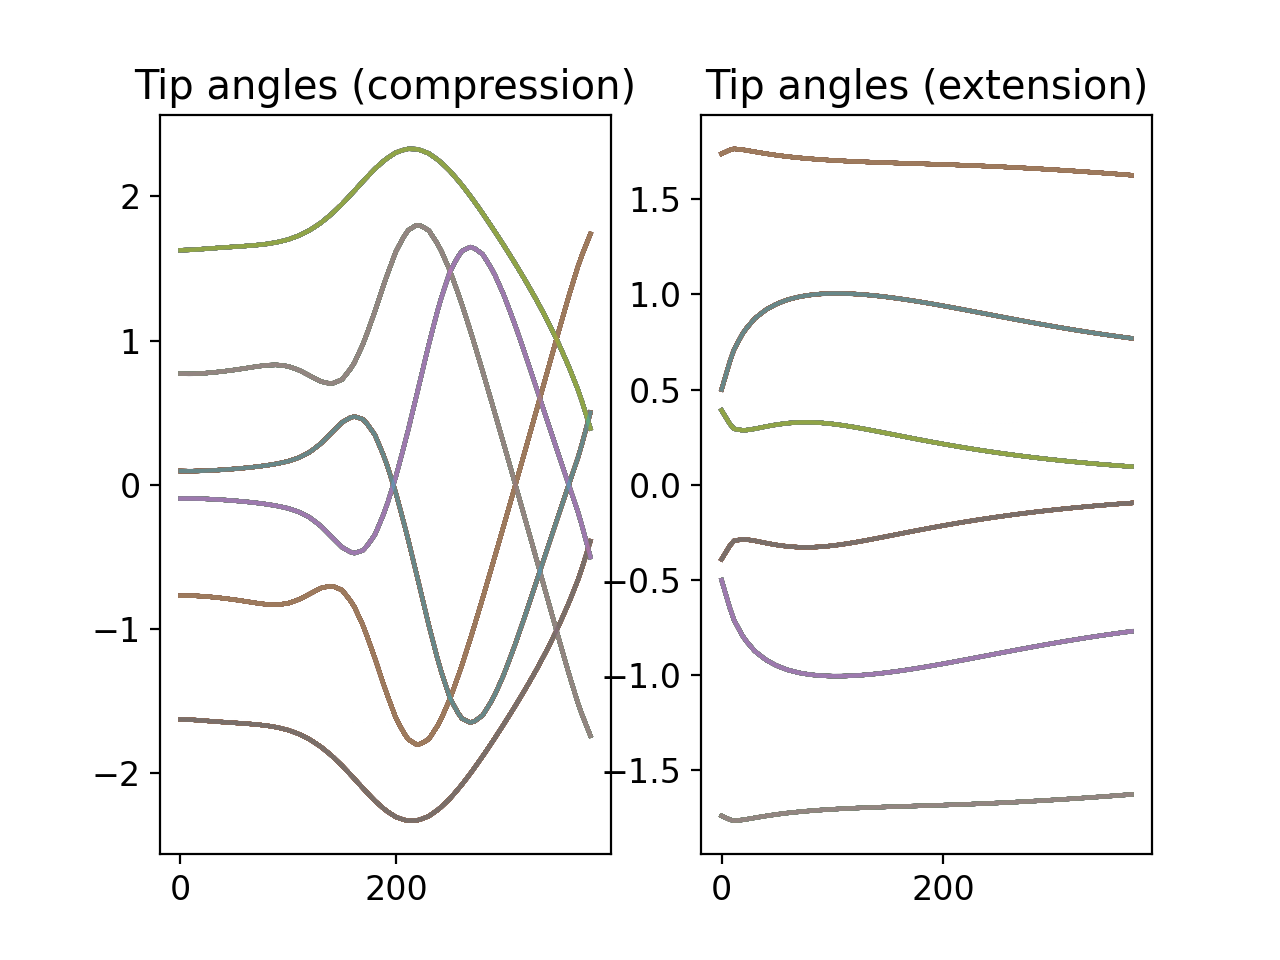

In [117]:
# Plot the tip angles during Compression and Extension

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols = 2)
for ii in range(100, 500):
    
    ax0.plot(filament.derived_data['common time array']['compression'], filament.derived_data['Tip angle']['compression'][ii, :], alpha = 0.5)
    ax1.plot(filament.derived_data['common time array']['extension'], filament.derived_data['Tip angle']['extension'][ii, :], alpha = 0.5)

ax0.set_title('Tip angles (compression)')
ax1.set_title('Tip angles (extension)')

plt.show()



<IPython.core.display.Javascript object>


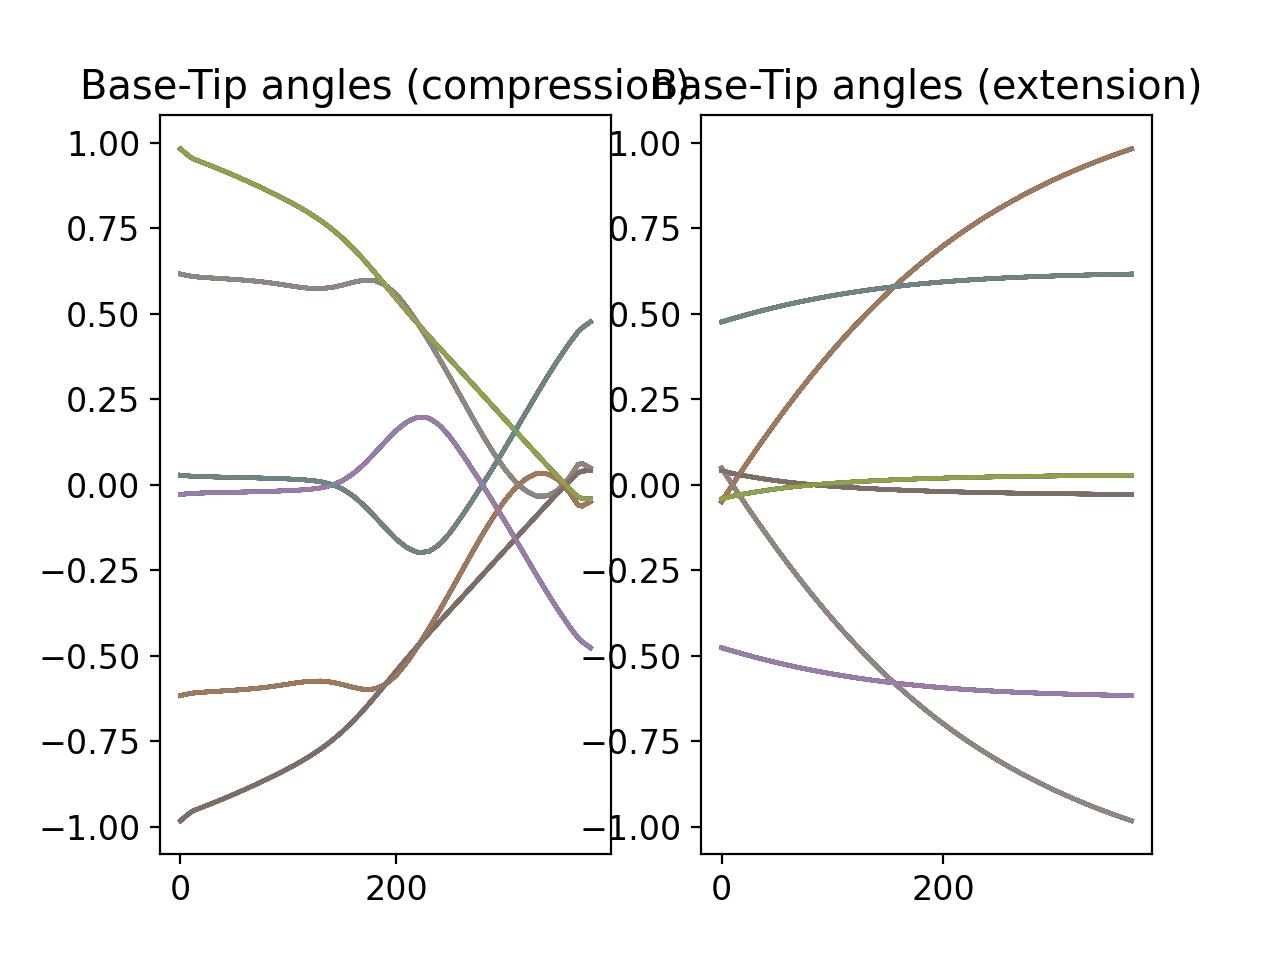

In [118]:
# Plot the base tip angles during Compression and Extension

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols = 2)
for ii in range(100, 500):
    
    ax0.plot(filament.derived_data['common time array']['compression'], filament.derived_data['Base-Tip angle']['compression'][ii, :], alpha = 0.5)
    ax1.plot(filament.derived_data['common time array']['extension'], filament.derived_data['Base-Tip angle']['extension'][ii, :], alpha = 0.5)

ax0.set_title('Base-Tip angles (compression)')
ax1.set_title('Base-Tip angles (extension)')

plt.show()

## Distribution of reorientation angles
Change in tip angle after a compression phase or extension phase

## Plot the tip reorientation angles during compression and extension

<IPython.core.display.Javascript object>


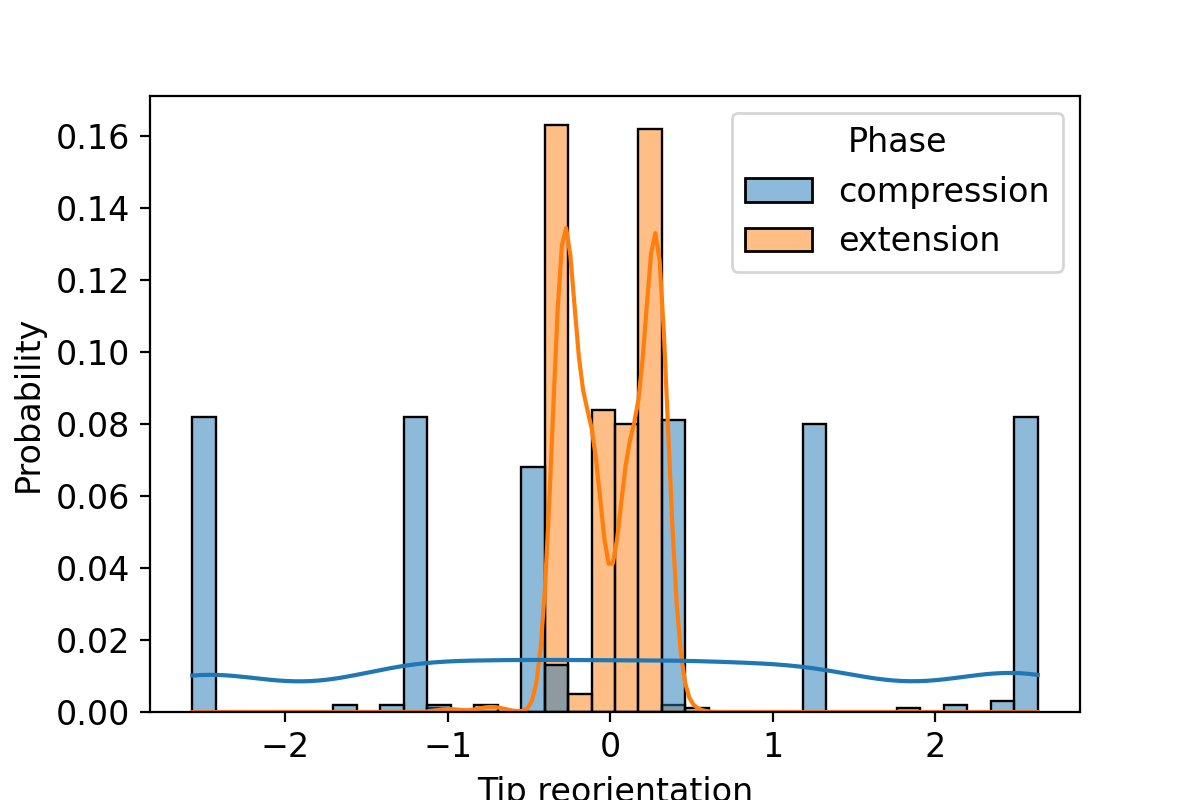

In [119]:



title = 'Tip angle reorientation distribution'

plt.figure(figsize = (6,4))

sns.histplot(data = df_reorientation, x = 'Tip reorientation', hue = 'Phase', kde=True, fill = True, stat="probability")
# ax0.set_title('Compression')
# ax0.set_xlim([min_angle, max_angle])

# sns.histplot(filament.derived_data['Tip reorientation']['extension'], ax = ax1, kde=True, color = 'b', fill = True, stat="probability")
# ax1.set_title('Extension')


# file_name = filament.dataName[:-5] +'_'+title 

# file_path = filament.analysisFolder

# if(not os.path.exists(file_path)):
#     os.makedirs(file_path)

# plt.savefig(os.path.join(file_path, file_name + '.png'), dpi = 300, bbox_inches = 'tight')


plt.show()

### Distribution of Base-tip reorientation angles

<IPython.core.display.Javascript object>


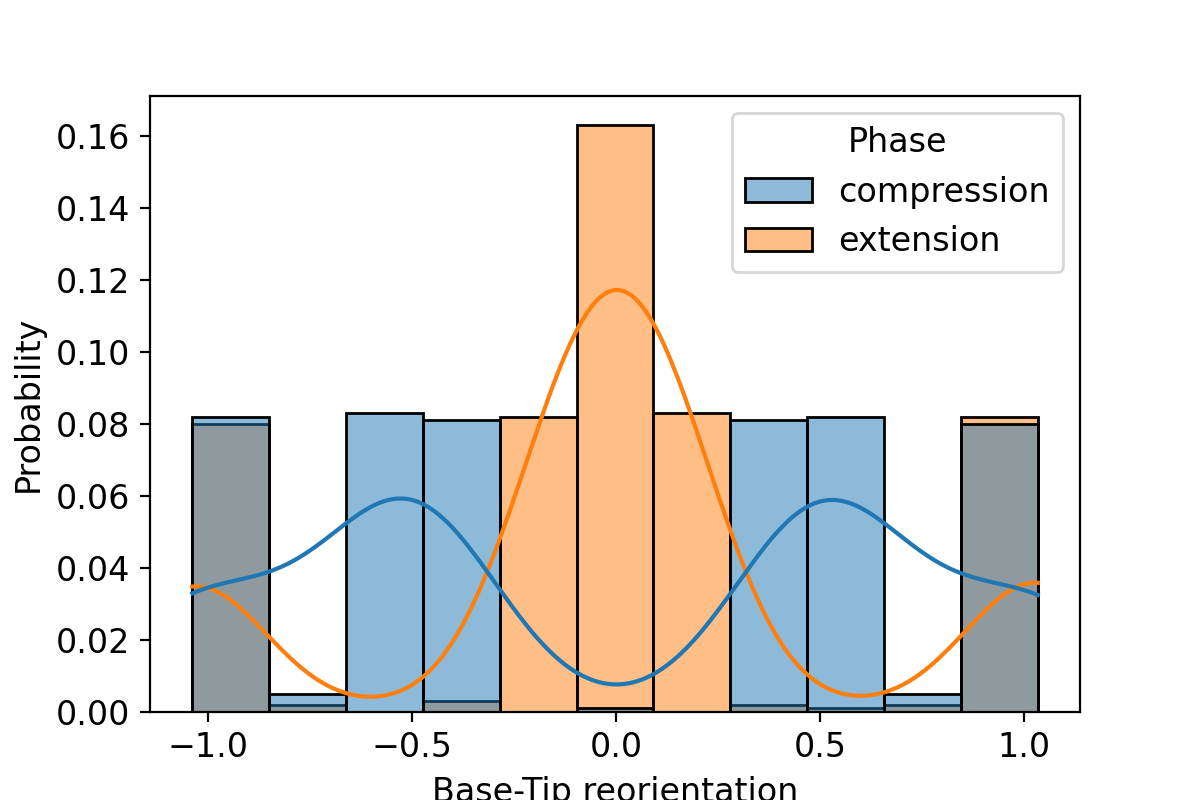

In [120]:
# Plot the Base-tip reorientation angles during compression and extension
title = 'base-Tip angle reorientation distribution'

plt.figure(figsize = (6,4))

sns.histplot(data = df_reorientation, x = 'Base-Tip reorientation', hue = 'Phase', kde=True, fill = True, stat="probability")
# ax0.set_title('Compression')
# ax0.set_xlim([min_angle, max_angle])

# sns.histplot(filament.derived_data['Tip reorientation']['extension'], ax = ax1, kde=True, color = 'b', fill = True, stat="probability")
# ax1.set_title('Extension')


# file_name = filament.dataName[:-5] +'_'+title 

# file_path = filament.analysisFolder

# if(not os.path.exists(file_path)):
#     os.makedirs(file_path)

# plt.savefig(os.path.join(file_path, file_name + '.png'), dpi = 300, bbox_inches = 'tight')


plt.show()


## Orientation decorrelation function
Calculates the orientation decorrelation function during compressive and extensional phases

### Save the orientation decorrelation data to file

In [77]:
# Create a data folder and save the processed data
root_folder = '/home/deepak/Dropbox/LacryModeling/processed_data/'




### Plot Tip Orientation decorrelation

<IPython.core.display.Javascript object>


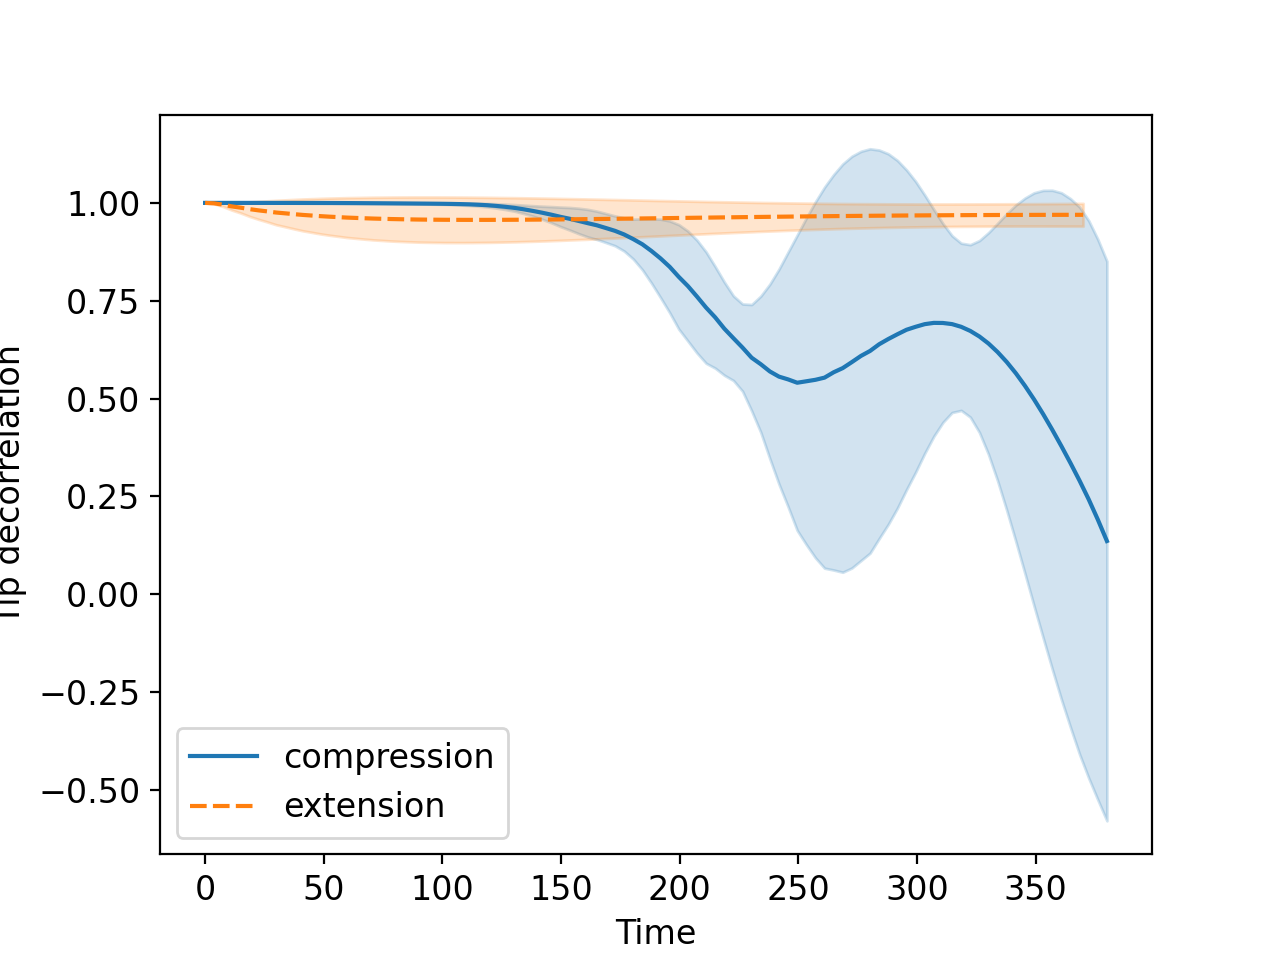

In [121]:
## Average orientation decorrelation (Tip angle)

plt.figure()

title = 'Tip Orientation decorrelation function (mean)'
sns.lineplot(x = 'Time', y = 'Tip decorrelation', data = df_orient_decorr, style = 'Phase', hue = 'Phase', ci = 'sd')

plt.legend()

# file_path = filament.analysis_folder
# if(not os.path.exists(file_path)):
#     os.makedirs(file_path)
    
# file_name = filament.dataName[:-5] +'_'+title
# plt.savefig(os.path.join(file_path, file_name + '.png'), dpi = 300, bbox_inches = 'tight')
# plt.savefig(os.path.join(file_path, file_name + '.svg'), dpi = 300, bbox_inches = 'tight')

plt.show()



### Base-Tip Orientation decorrelation

<IPython.core.display.Javascript object>


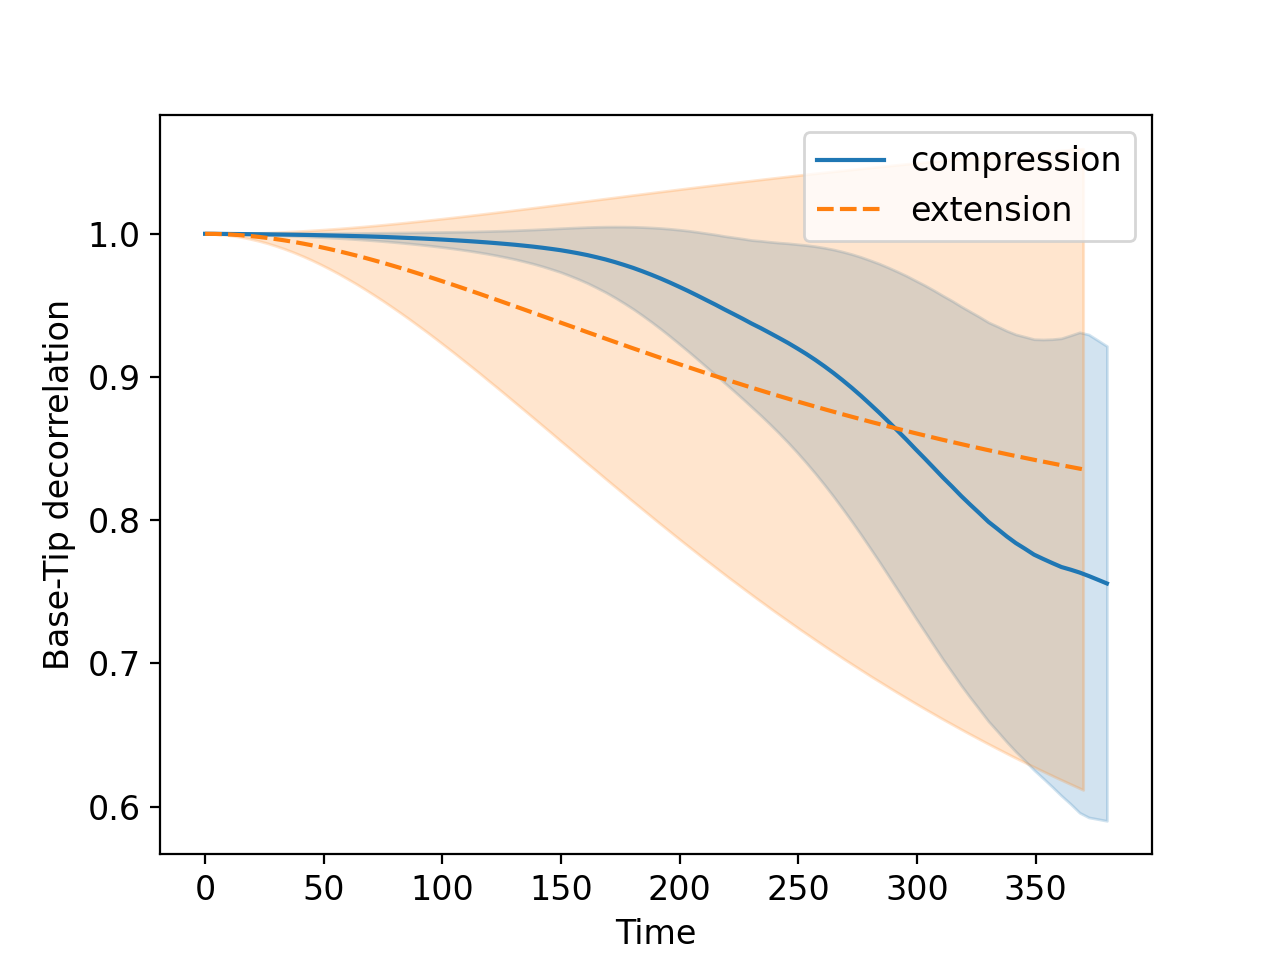

In [122]:
## Plot the Base-Tip orientation decorrelation for the whole simulation

plt.figure()

title = 'Base-Tip Orientation decorrelation function (mean)'
sns.lineplot(x = 'Time', y = 'Base-Tip decorrelation', data = df_orient_decorr, style = 'Phase', hue = 'Phase', ci = 'sd')

plt.legend()

# file_path = filament.analysis_folder
# if(not os.path.exists(file_path)):
#     os.makedirs(file_path)
    
# file_name = filament.dataName[:-5] +'_'+title
# plt.savefig(os.path.join(file_path, file_name + '.png'), dpi = 300, bbox_inches = 'tight')
# plt.savefig(os.path.join(file_path, file_name + '.svg'), dpi = 300, bbox_inches = 'tight')

plt.show()

---

# Return Maps

---

## Return map of Filament tip angle ($\theta_{n+1}$ vs $\theta_n$)

***

In [72]:
tip_angle_phase_0 = filament.derived_data['tip angle'][constant_phase_compression]

time_array = filament.Time[constant_phase_compression]
activity_cycle = np.array(time_array/filament.activity_timescale, dtype = int)

start_cycle = 100

<IPython.core.display.Javascript object>


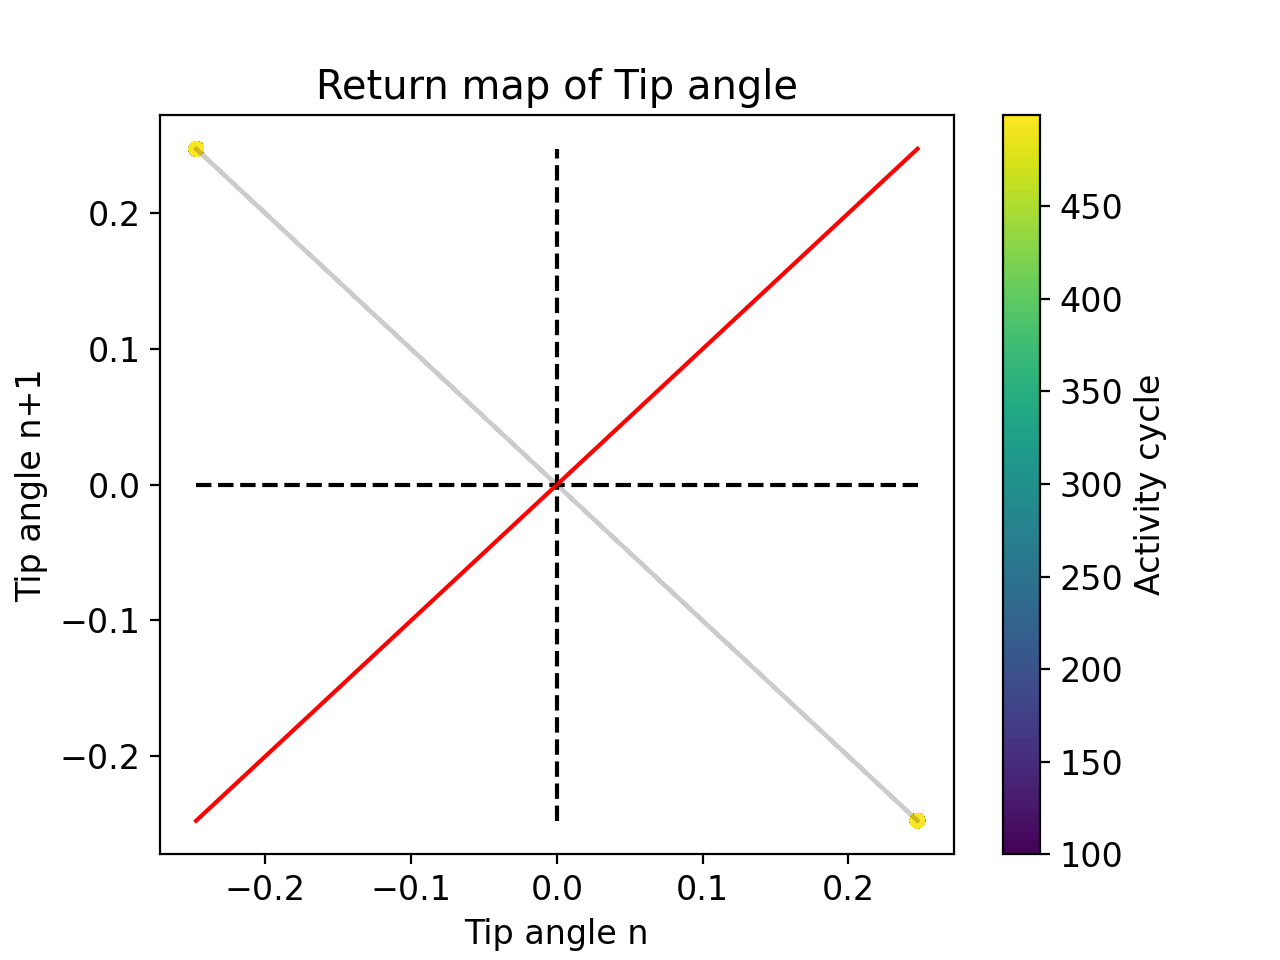

In [73]:
plt.figure()
title = 'Tip angle'

angle_min = np.min(tip_angle_phase_0)
angle_max = np.max(tip_angle_phase_0)

diag_line_x = np.linspace(angle_min, angle_max, 20)
diag_line_y = diag_line_x

ax2 = plt.plot(diag_line_x, diag_line_y, 'r-')
ax2 = plt.hlines(0, angle_min, angle_max, color = 'k', linestyle = '--')
ax2 = plt.vlines(0, angle_min, angle_max, color = 'k', linestyle = '--')

ax2 = plt.plot(tip_angle_phase_0[start_cycle:-1], tip_angle_phase_0[start_cycle+1:], color = 'k', alpha =0.2)

ax1 = plt.scatter(tip_angle_phase_0[start_cycle:-1], tip_angle_phase_0[start_cycle+1:], 20, c = activity_cycle[start_cycle:-1])




plt.xlabel('Tip angle '+'n')
plt.ylabel('Tip angle '+'n+1')
plt.title('Return map of '+ title)
cbar = plt.colorbar(ax1)
cbar.ax.set_ylabel('Activity cycle')


# file_path = filament.analysis_folder
# if(not os.path.exists(file_path)):
#     os.makedirs(file_path)

# file_name = filament.dataName[:-5] +'_'+title
# plt.savefig(os.path.join(file_path, file_name + '.png'), dpi = 300, bbox_inches = 'tight')
# plt.savefig(os.path.join(file_path, file_name + '.svg'), dpi = 300, bbox_inches = 'tight')

plt.show()

## Return Map of Filament Base Tip Angle

In [74]:
filament.compute_base_tip_angle()

base_tip_angle_phase_0 = filament.derived_data['base tip angle'][constant_phase_compression]

In [ ]:
# Save the data for plotting
root_folder = '/home/deepak/Dropbox/LacryModeling/processed_data/'


<IPython.core.display.Javascript object>


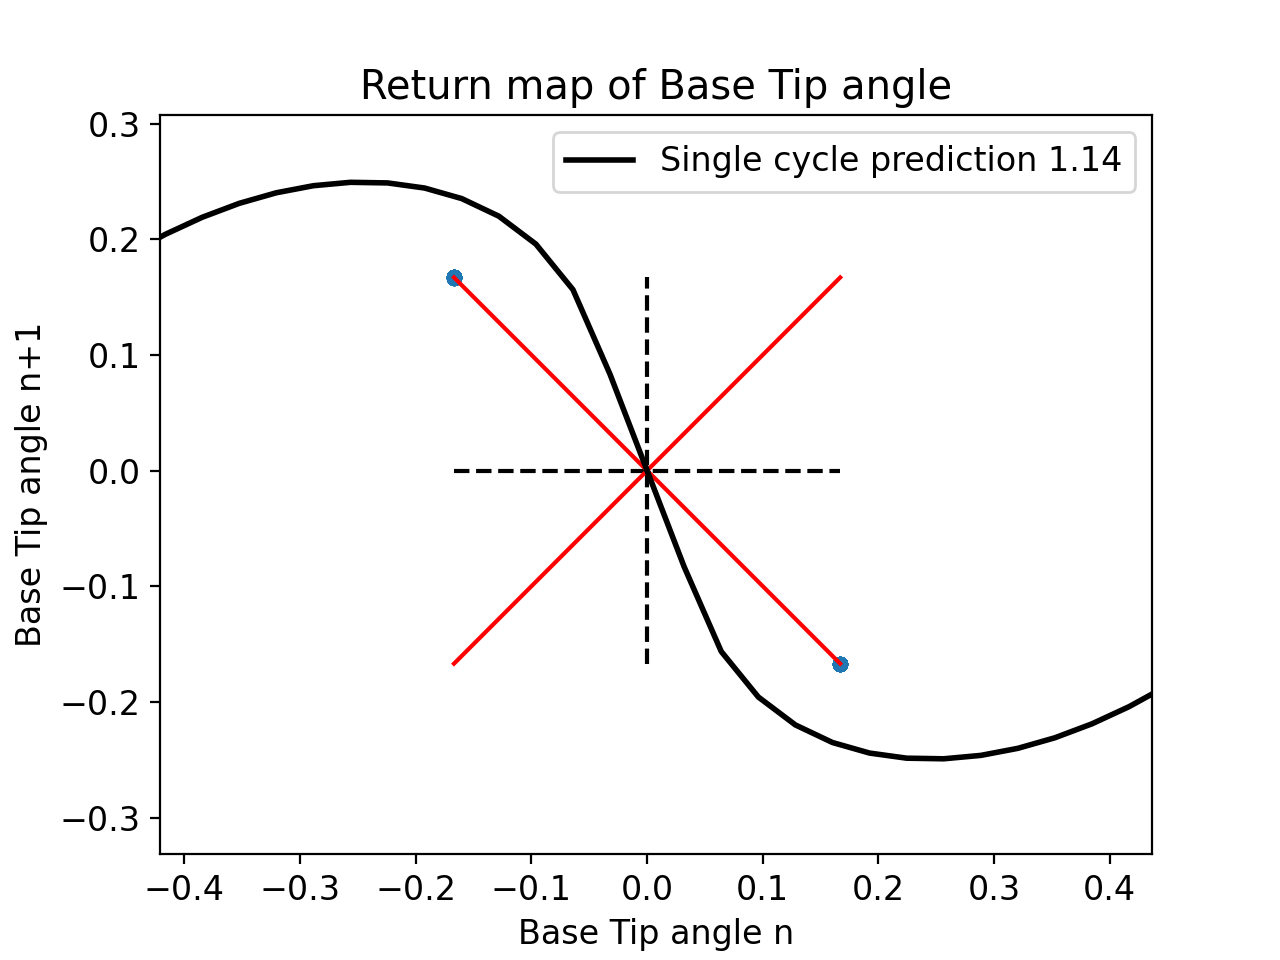

In [76]:
# Load the single-cycle prediction if available
import pandas as pd

# single_cycle_file = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_sweep_k_25/buckling_escape_angles_750_1.52564102564103.csv'
# single_cycle_file = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/2021-12-15/buckling_escape_angles_750_1.52564102564103.csv'
# single_cycle_file = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_k_25_extension_first/buckling_escape_angles_750_2.736842105263158.csv'
# single_cycle_file = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_k_25_extension_first/buckling_escape_angles_750_1.07692307692308.csv'

single_cycle_file = '/home/deepak/ActiveFilamentsSearch_backup_3/FollowerForce_BucklingDynamics_Simulations/activity_strength_k_25_extension_first/buckling_escape_angles_750_1.1410256410256399.csv'
df_single_cycle = None

if os.path.exists(single_cycle_file):
    df_single_cycle = pd.read_csv(single_cycle_file)
    df_single_cycle['-Initial angle (rad)'] = -df_single_cycle['Initial angle (rad)']
    df_single_cycle['-Final angle (rad)'] = -df_single_cycle['Final angle (rad)']
    



plt.figure()
title = 'Base Tip angle'

angle_min = np.min(base_tip_angle_phase_0)
angle_max = np.max(base_tip_angle_phase_0)

diag_line_x = np.linspace(angle_min, angle_max, 20)
diag_line_y = diag_line_x

ax2 = plt.plot(diag_line_x, diag_line_y, 'r-')
ax2 = plt.plot(diag_line_x, -diag_line_y, 'r-')
ax2 = plt.hlines(0, angle_min, angle_max, color = 'k', linestyle = '--')
ax2 = plt.vlines(0, angle_min, angle_max, color = 'k', linestyle = '--')

# ax1 = plt.scatter(base_tip_angle_phase_0[start_cycle:-1], base_tip_angle_phase_0[start_cycle+1:], 20, c = activity_cycle[start_cycle:-1])
ax1 = plt.scatter(base_tip_angle_phase_0[start_cycle:-1], base_tip_angle_phase_0[start_cycle+1:], 20)

# ax2 = plt.plot(base_tip_angle_phase_0[start_cycle:-1], base_tip_angle_phase_0[start_cycle+1:], color = 'k', alpha =0.2)




plt.xlabel('Base Tip angle '+'n')
plt.ylabel('Base Tip angle '+'n+1')
plt.title('Return map of '+ title)
# cbar = plt.colorbar(ax1)
cbar.ax.set_ylabel('Activity cycle')


file_path = filament.analysisFolder
if(not os.path.exists(file_path)):
    os.makedirs(file_path)

plt.axis('equal')
file_name = filament.dataName[:-5] +'_'+title
plt.savefig(os.path.join(file_path, file_name + '.png'), dpi = 300, bbox_inches = 'tight')
# plt.savefig(os.path.join(file_path, file_name + '.svg'), dpi = 300, bbox_inches = 'tight')

# If Single-cycle data exists plot it
if(df_single_cycle is not None):
    ax3 = sns.lineplot(x='Initial angle (rad)', y = 'Final angle (rad)',  
             data = df_single_cycle, color = 'k', linewidth = 2, label = 'Single cycle prediction {}'.format(df_single_cycle['d0'][0]))
    ax4 = sns.lineplot(x='-Initial angle (rad)', y = '-Final angle (rad)',  
             data = df_single_cycle, color = 'k', linewidth = 2)

# plt.xlim(-angle_max, angle_max)
# plt.ylim(-angle_max, angle_max)
file_name = filament.dataName[:-5] +'_'+title+'SingleCyclePrediction'
plt.savefig(os.path.join(file_path, file_name + '.png'), dpi = 300, bbox_inches = 'tight')
# plt.savefig(os.path.join(file_path, file_name + '.svg'), dpi = 300, bbox_inches = 'tight')
plt.show()

### Change in Base Tip angle

<IPython.core.display.Javascript object>


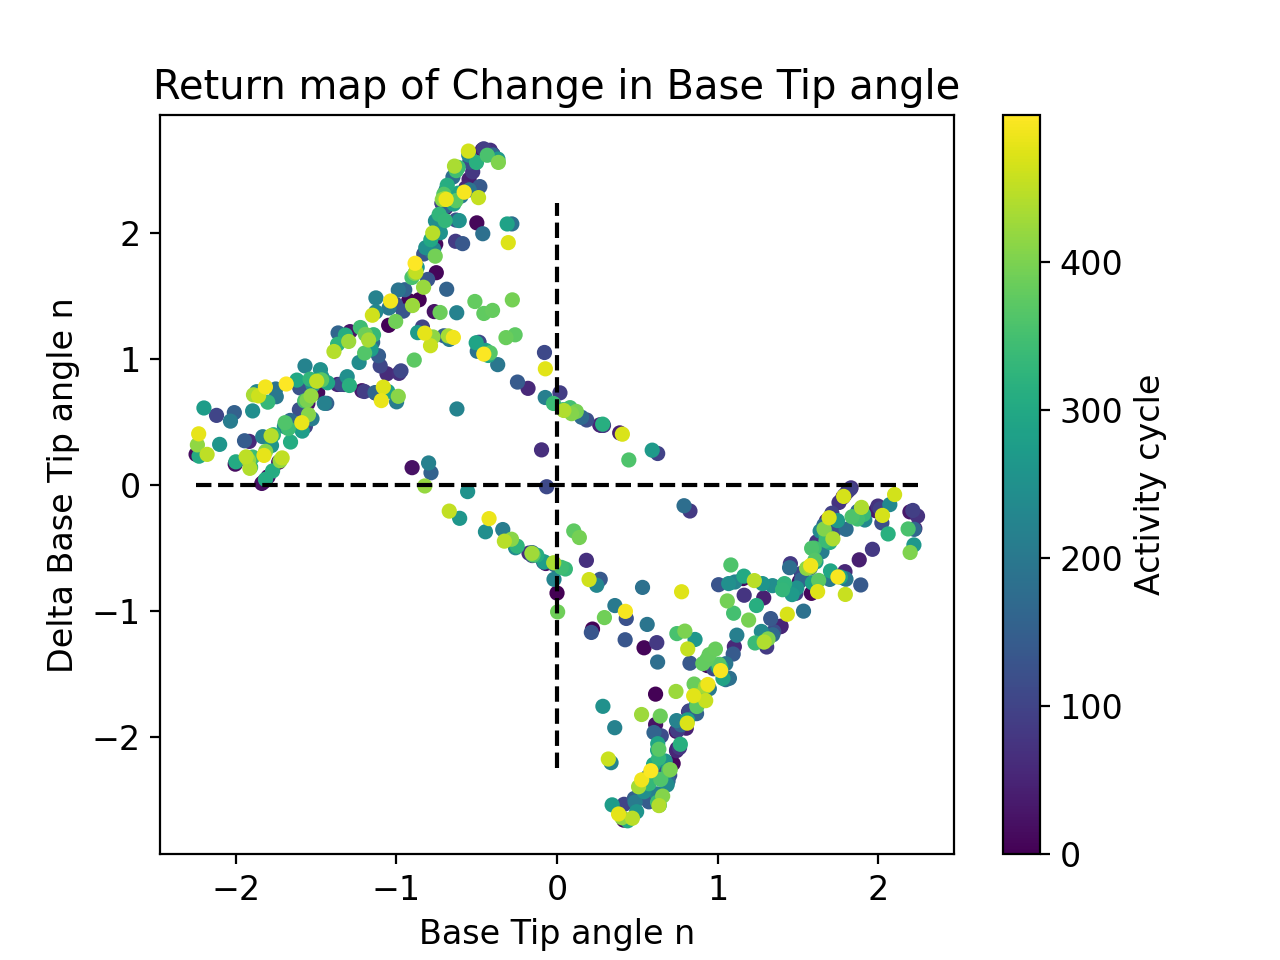

In [194]:
plt.figure()
start_cycle=0
title = 'Change in Base Tip angle'

angle_min = np.min(base_tip_angle_phase_0)
angle_max = np.max(base_tip_angle_phase_0)

# diag_line_x = np.linspace(angle_min, angle_max, 20)
# diag_line_y = diag_line_x

# ax2 = plt.plot(diag_line_x, diag_line_y, 'r-')
# ax2 = plt.plot(diag_line_x, -diag_line_y, 'r-')
ax2 = plt.hlines(0, angle_min, angle_max, color = 'k', linestyle = '--')
ax2 = plt.vlines(0, angle_min, angle_max, color = 'k', linestyle = '--')

ax1 = plt.scatter(base_tip_angle_phase_0[start_cycle:-1], base_tip_angle_phase_0[start_cycle+1:] - base_tip_angle_phase_0[start_cycle:-1], 20, c = activity_cycle[start_cycle:-1])

# ax2 = plt.plot(base_tip_angle_phase_0[:-1], base_tip_angle_phase_0[1:], color = 'k', alpha =0.2)



plt.xlabel('Base Tip angle '+'n')
plt.ylabel('Delta Base Tip angle '+'n')
plt.title('Return map of '+ title)
cbar = plt.colorbar(ax1)
cbar.ax.set_ylabel('Activity cycle')

file_path = filament.analysisFolder
if(not os.path.exists(file_path)):
    os.makedirs(file_path)

file_name = filament.dataName[:-5] +'_'+title
plt.savefig(os.path.join(file_path, file_name + '.png'), dpi = 300, bbox_inches = 'tight')

## Tangent angle dynamics over whole simulation

<IPython.core.display.Javascript object>


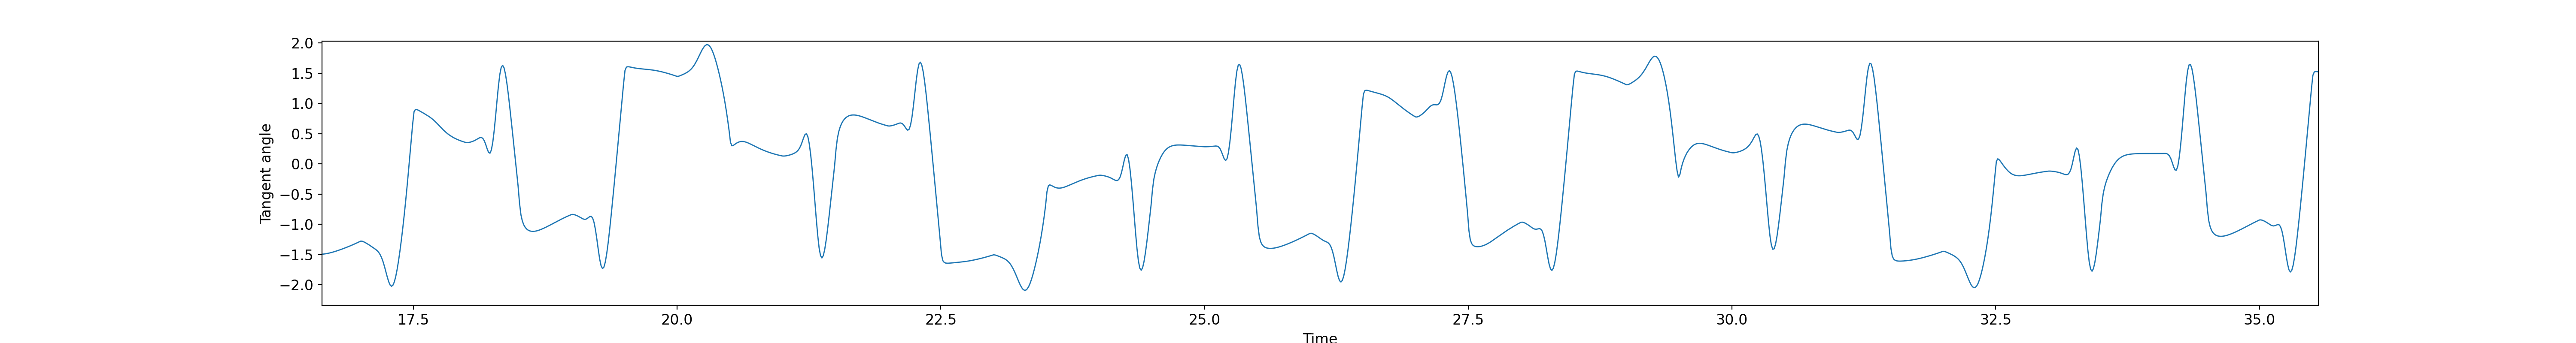

In [330]:
time_array = range(int(filament.Nt))
plt.figure(figsize = (30,4))
plt.plot(filament.Time/filament.activity_timescale, filament.derived_data['tip angle'], linewidth = 1)
# plt.vlines(filament.Time[constant_phase_compression]/filament.activity_timescale, min(filament.derived_data['tip angle']), max(filament.derived_data['tip angle']), 'r', alpha = 0.5)
# plt.vlines(filament.Time[constant_phase_extension]/filament.activity_timescale, min(filament.derived_data['tip angle']), max(filament.derived_data['tip angle']), 'g', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('Tangent angle')
ax = plt.gca()
# ax.set_aspect(1)
# plt.savefig(os.path.join(file_path, filament.dataName[:-5]+'TangentAngle_At_Tip.png'), dpi = 300)
plt.show()

<IPython.core.display.Javascript object>


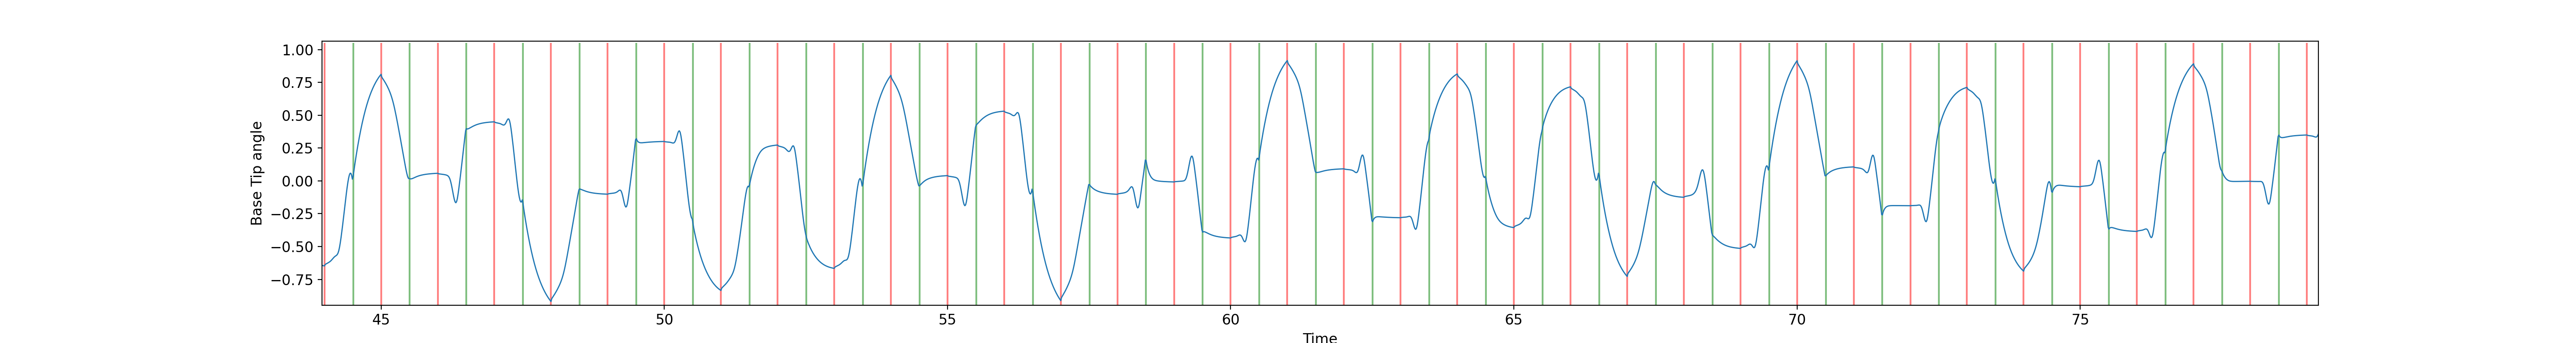

In [331]:
## Base-tip angle over whole simulation

time_array = range(int(filament.Nt))
plt.figure(figsize = (30,4))
plt.plot(filament.Time/filament.activity_timescale, filament.derived_data['base tip angle'], linewidth = 1)
plt.vlines(filament.Time[constant_phase_compression]/filament.activity_timescale, min(filament.derived_data['base tip angle']), max(filament.derived_data['base tip angle']), 'r', alpha = 0.5)
plt.vlines(filament.Time[constant_phase_extension]/filament.activity_timescale, min(filament.derived_data['base tip angle']), max(filament.derived_data['base tip angle']), 'g', alpha = 0.5)

plt.xlabel('Time')
plt.ylabel('Base Tip angle')
ax = plt.gca()
# ax.set_aspect(1)
# plt.savefig(os.path.join(file_path, filament.dataName[:-5]+'TangentAngle_At_Tip.png'), dpi = 300)
plt.show()

In [307]:
# Find the local maxima and minima of the Tip angles time series
min_peak = min(filament.derived_data['tip angle'])
max_peak = max(filament.derived_data['tip angle'])
max_peaks, props = signal.find_peaks(filament.derived_data['tip angle'], (0.2*max_peak, max_peak))

min_peaks, props = signal.find_peaks(-filament.derived_data['tip angle'], (-0.2*min_peak, -min_peak))

print(max_peaks)
print(min_peaks)

[  412   485   862   937  1160  1387  1459  1613  1684  1836  1912  1988
  2062  2213  2285  2510  2738  2809  2961  3037  3112  3187  3263  3336
  3560  3784  4387  4461  4684  5063  5134  5288  5359  5511  5588  5662
  5737  5812  5886  6188  6259  6411  6488  6562  6637  6713  6786  7010
  7234  7836  8059  8213  8284  8437  8511  8736  9038  9109  9262  9335
  9786  9862  9938 10012 10088 10162 10238 10311 10540 10609 10763 10833
 10985 11209 11888 11959 12113 12184 12336 12412 12487 12562 12637 12712
 12863 12934 13087 13159 13312 13385 13763 13835 14062 14135 14363 14434
 14587 14662 14884 15113 15184 15337 15412 15635 15861 16463 16535 17063
 17137 17212 17287 17362 17438 17512 17587 17662 17738 17811 18035 18259
 18639 18711 18934 19463 19534 19688 19759 19911 19988 20062 20137 20212
 20287 20439 20509 20663 20733 20885 21109 21562 21635 22014 22085 22311
 22388 22462 22537 23362 23437 23659 23887 23963 24037 24112 24337 24412
 24637 24709 24862 24935 25538 25609 25763 25834 25

<IPython.core.display.Javascript object>


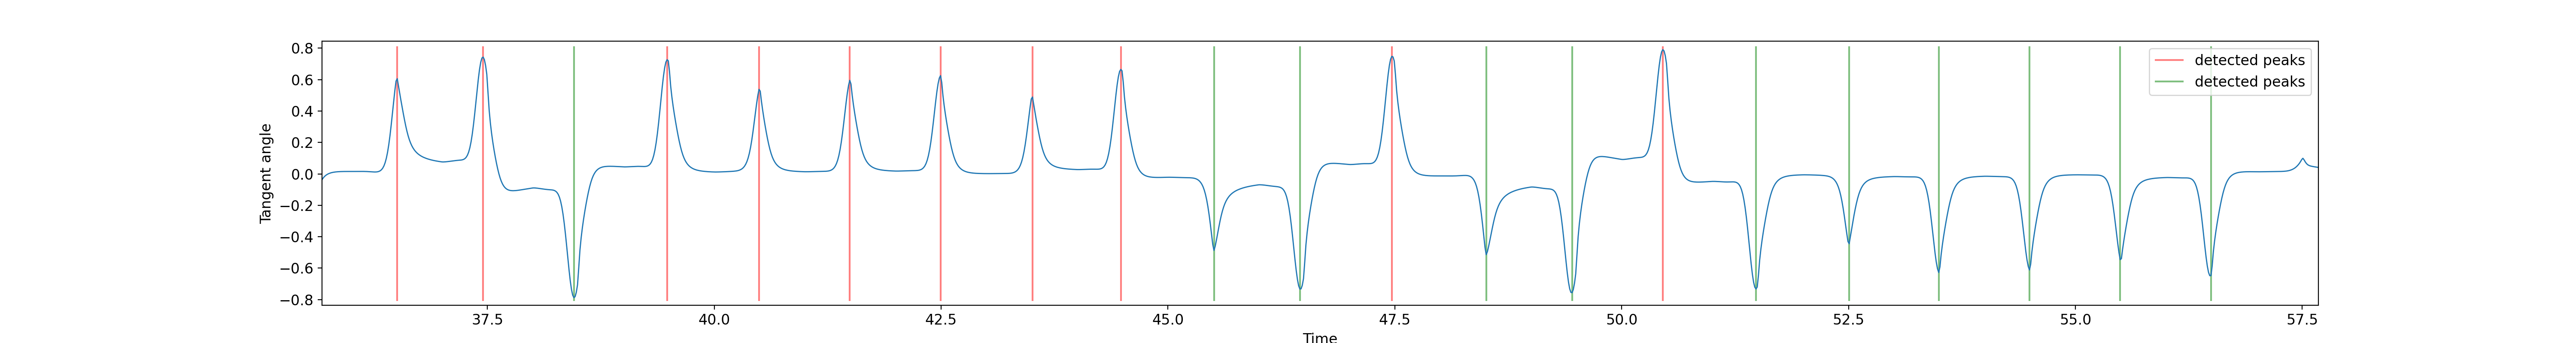

In [308]:
plt.figure(figsize = (30,4))
plt.plot(filament.Time/filament.activity_timescale, filament.derived_data['tip angle'], linewidth = 1)
plt.vlines(filament.Time[max_peaks]/filament.activity_timescale, min(filament.derived_data['tip angle']), max(filament.derived_data['tip angle']), 'r', alpha = 0.5, label = 'detected peaks')
plt.vlines(filament.Time[min_peaks]/filament.activity_timescale, min(filament.derived_data['tip angle']), max(filament.derived_data['tip angle']), 'g', alpha = 0.5, label = 'detected peaks')

plt.xlabel('Time')
plt.ylabel('Tangent angle')
plt.legend()
ax = plt.gca()
# ax.set_aspect(1)
# plt.savefig(os.path.join(file_path, filament.dataName[:-5]+'TangentAngle_At_Tip.png'), dpi = 300)
plt.show()

<IPython.core.display.Javascript object>


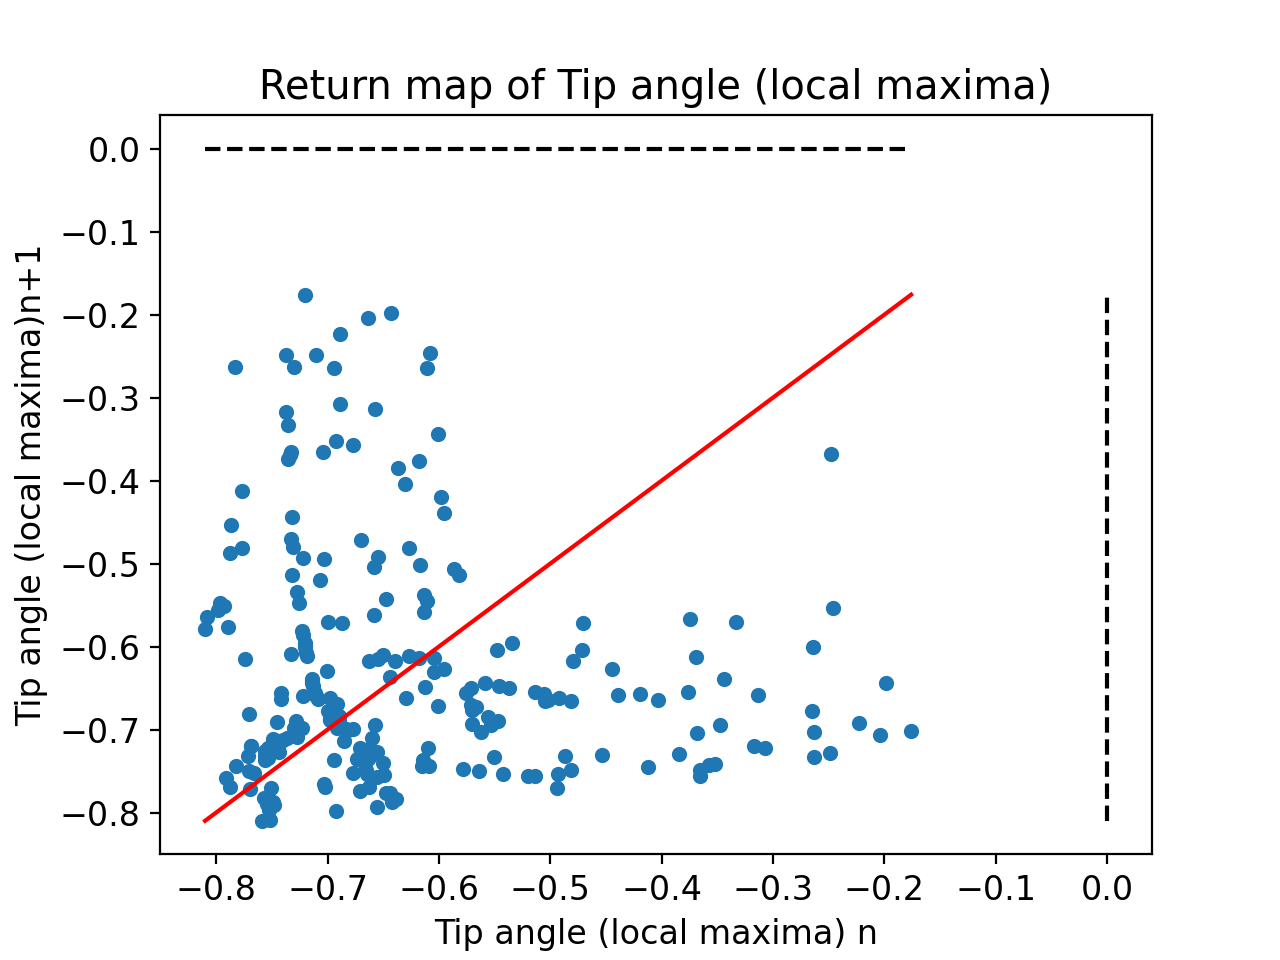

In [313]:
## Return map of the maxima of the tip angles

plt.figure()
title = 'Tip angle (local maxima)'

all_peaks = np.sort(np.concatenate((min_peaks, max_peaks)))

# tip_angle_maxima = filament.derived_data['tip angle'][all_peaks]

tip_angle_maxima = filament.derived_data['tip angle'][min_peaks]
# tip_angle_maxima = tip_angle_maxima[-100:]

angle_min = np.min(tip_angle_maxima)
angle_max = np.max(tip_angle_maxima)

diag_line_x = np.linspace(angle_min, angle_max, 20)
diag_line_y = diag_line_x

ax2 = plt.plot(diag_line_x, diag_line_y, 'r-')
ax2 = plt.hlines(0, angle_min, angle_max, color = 'k', linestyle = '--')
ax2 = plt.vlines(0, angle_min, angle_max, color = 'k', linestyle = '--')

ax1 = plt.scatter(tip_angle_maxima[:-1], tip_angle_maxima[1:], 20)




plt.xlabel('Tip angle (local maxima) '+'n')
plt.ylabel('Tip angle (local maxima)'+'n+1')
plt.title('Return map of '+ title)
# cbar = plt.colorbar(ax1)
# cbar.ax.set_ylabel('Activity cycle')


file_path = filament.analysis_folder
if(not os.path.exists(file_path)):
    os.makedirs(file_path)

file_name = filament.dataName[:-5] +'_'+title
# plt.savefig(os.path.join(file_path, file_name + '.png'), dpi = 300, bbox_inches = 'tight')
# plt.savefig(os.path.join(file_path, file_name + '.svg'), dpi = 300, bbox_inches = 'tight')

plt.show()

In [260]:
len(all_peaks)

479

In [257]:
max_peaks

array([  412,   485,   862,   937,  1160,  1387,  1459,  1613,  1684,
        1836,  1912,  1988,  2062,  2213,  2285,  2510,  2738,  2809,
        2961,  3037,  3112,  3187,  3263,  3336,  3560,  3784,  4387,
        4461,  4684,  5063,  5134,  5288,  5359,  5511,  5588,  5662,
        5737,  5812,  5886,  6188,  6259,  6411,  6488,  6562,  6637,
        6713,  6786,  7010,  7234,  7836,  8059,  8213,  8284,  8437,
        8511,  8736,  9038,  9109,  9262,  9335,  9786,  9862,  9938,
       10012, 10088, 10162, 10238, 10311, 10540, 10609, 10763, 10833,
       10985, 11209, 11888, 11959, 12113, 12184, 12336, 12412, 12487,
       12562, 12637, 12712, 12863, 12934, 13087, 13159, 13312, 13385,
       13763, 13835, 14062, 14135, 14363, 14434, 14587, 14662, 14884,
       15113, 15184, 15337, 15412, 15635, 15861, 16463, 16535, 17063,
       17137, 17212, 17287, 17362, 17438, 17512, 17587, 17662, 17738,
       17811, 18035, 18259, 18639, 18711, 18934, 19463, 19534, 19688,
       19759, 19911,